<a href="https://colab.research.google.com/github/cidcom/satellite-cloud-removal-dip/blob/main/01-Example-Use-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/cidcom/satellite-cloud-removal-dip/blob/main/01-Example-Use-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# GitHub import and package installation
These two actions should take about 1-2 minutes. Then you're ready to go.

🚀 **To use GPU go to** `Runtime` -> `Change Runtime Type` -> `Hardware Accelerator: GPU`

In [2]:
! git clone https://github.com/cidcom/satellite-cloud-removal-dip

Cloning into 'satellite-cloud-removal-dip'...
remote: Enumerating objects: 95, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 95 (delta 36), reused 49 (delta 11), pack-reused 0
Unpacking objects: 100% (95/95), 5.20 MiB | 6.43 MiB/s, done.


In [3]:
!pip install -q rasterio pytorch-lightning==1.8.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 80.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.4/798.4 kB 49.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [4]:
import sys
sys.path.append('./satellite-cloud-removal-dip/')

from src import *
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (20, 10)

## Example Cloud Image with a Cloud-Shadow Mask 🌥

In [5]:
s2_image = s2_preprocess('./satellite-cloud-removal-dip/data/example_sample/S2/S1_3c120554-3873-4de2-bcc3-23ae00d28c4f_S2_76dac503-47d7-446b-b92d-56f4dd10f8e2_0_0_256x256.tif')

with open('./satellite-cloud-removal-dip/data/example_sample/mask.npy', 'rb') as f:
    mask = np.load(f)

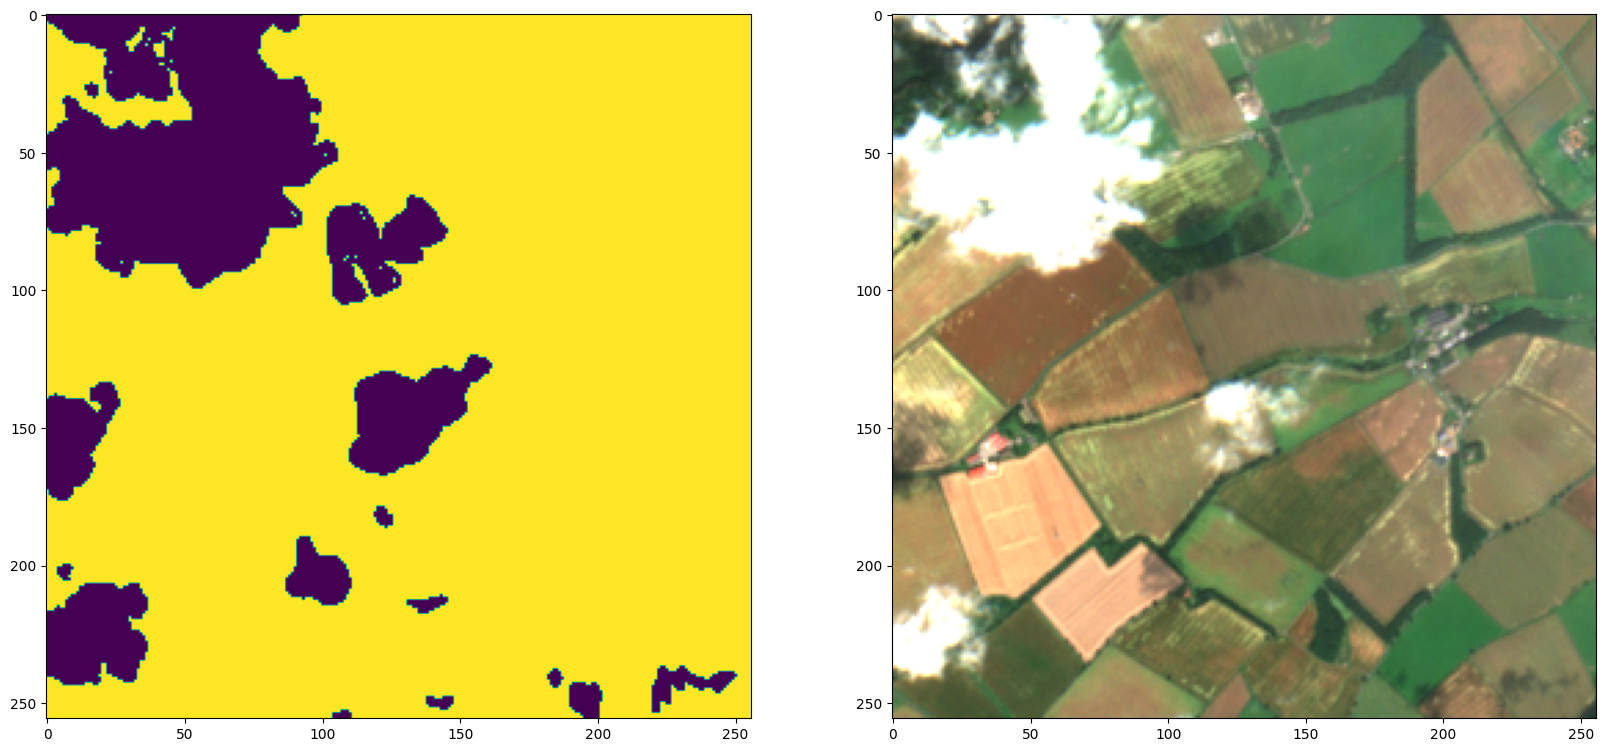

In [6]:
plt.subplot(1,2,1)
plt.imshow(mask)
plt.subplot(1,2,2)
plt.imshow(s2_image)

### Supporting Data: Sentinel-1 SAR and a yearly Sentinel-2 average from 2019

In [7]:
s1_image = s1_preprocess('./satellite-cloud-removal-dip/data/example_sample/S1/S1_3c120554-3873-4de2-bcc3-23ae00d28c4f_S2_76dac503-47d7-446b-b92d-56f4dd10f8e2_0_0_256x256.tif',
                         to_db = True)

with open('./satellite-cloud-removal-dip/data/2019_mean.npy', 'rb') as f:
    s2_mean = np.load(f)

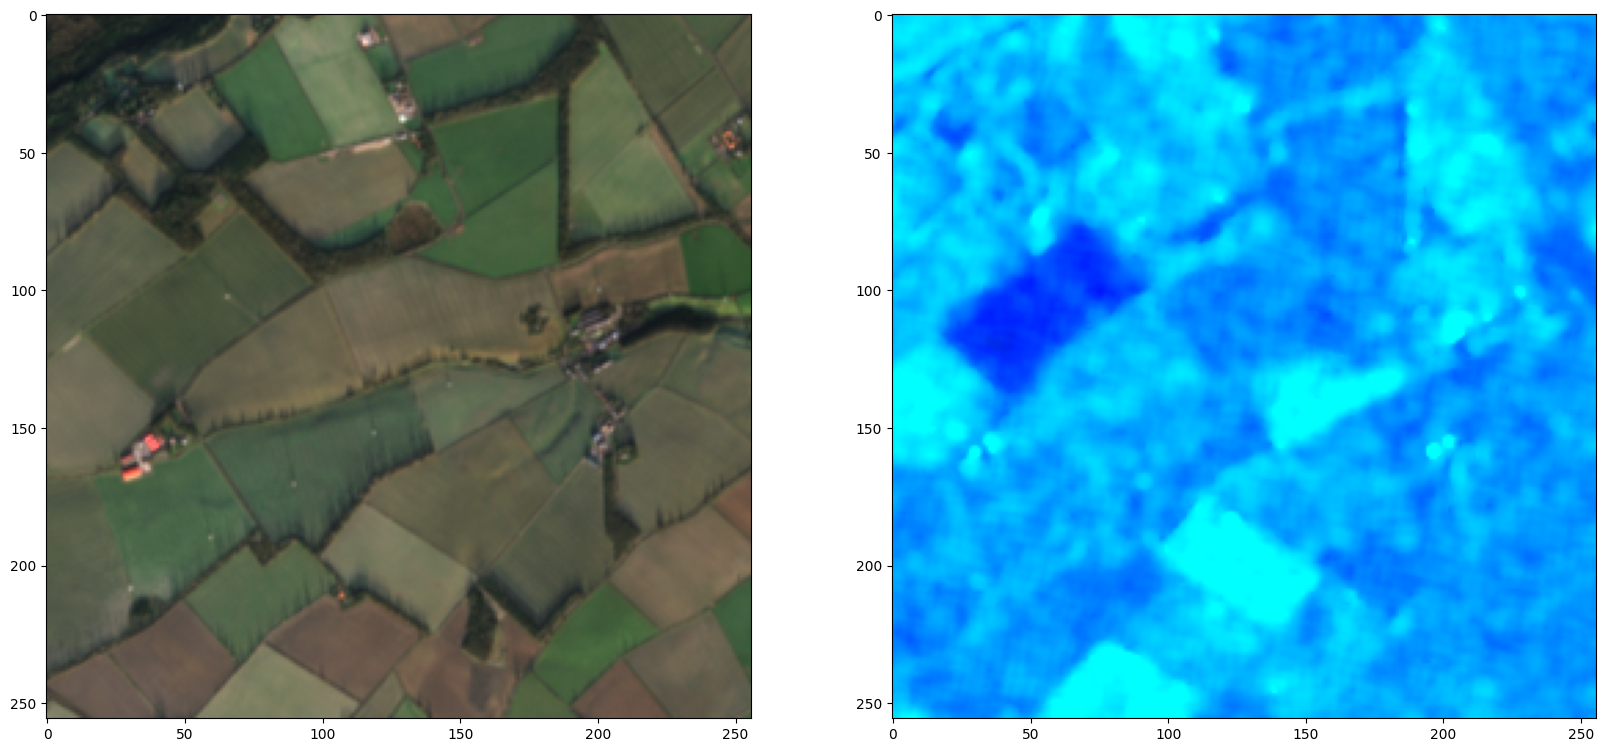

In [8]:
plt.subplot(1,2,1)
plt.imshow(s2_mean)
plt.subplot(1,2,2)
plt.imshow(rgb(s1_image))

## Initialize Model and Train 🏋
The ttraining should take about 10 minutes with the resources provided by Google Colab

In [9]:
my_model = LitDIP()

my_model.set_target([s2_image, s2_mean, s1_image])
my_model.set_mask([mask,
                   np.ones(mask.shape),
                   np.ones(mask.shape)])

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [10]:
trainer = pl.Trainer(
    max_epochs = 4,
    logger=False,
    gpus = [0]
)
trainer.fit(my_model)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 2.4 M 
-------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.769     Total estima

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4` reached.


In [11]:
result, _, _ = my_model.output() # the two unused (_) variables correspond to s2_mean reconstruction and s1_image reconstruction

Text(0.5, 1.0, 'Results')

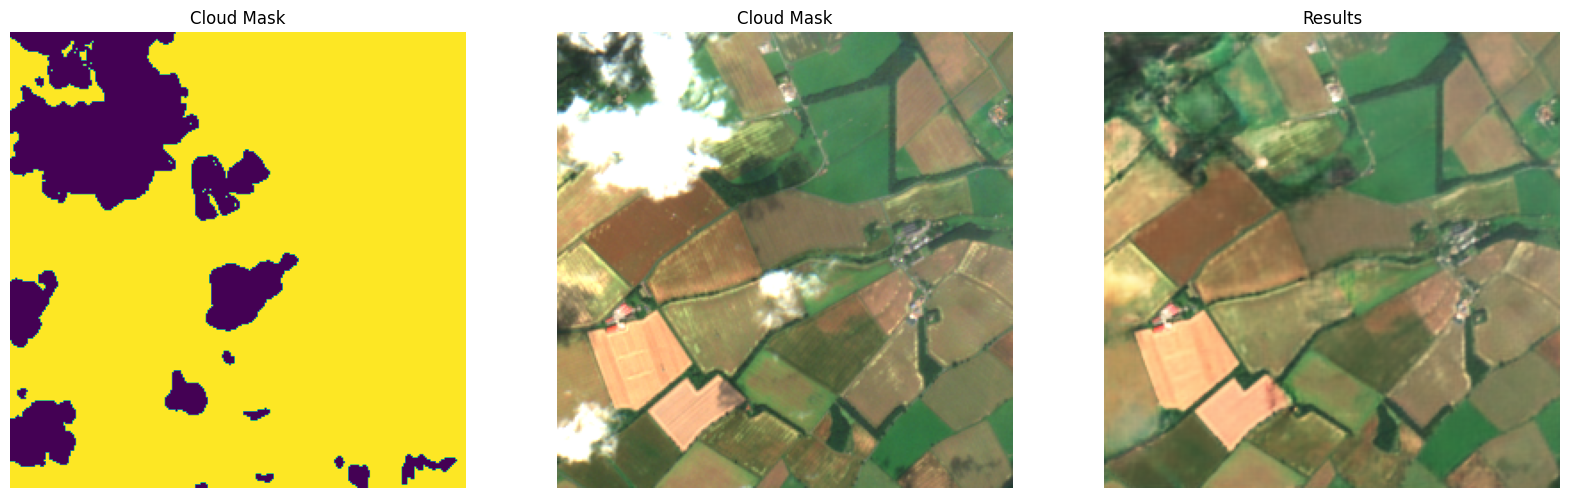

In [12]:
plt.subplot(1,3,1)
plt.imshow(mask)
plt.axis('off')
plt.title('Cloud Mask')
plt.subplot(1,3,2)
plt.imshow(s2_image)
plt.axis('off')
plt.title('Cloud Mask')
plt.subplot(1,3,3)
plt.imshow(result)
plt.axis('off')
plt.title('Results')